In [30]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.special
import scipy.stats as stats ## note this package is new this week

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Much of this code was borrowed and modified from
https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_02.ipynb

# Example: binomial distribution
Let's start out by looking at the binomial distribution

In [31]:
from scipy.special import loggamma
def dbinomial(k, n, p):
    ## Our improved binomial distribution from Week 2
    log_prob = loggamma(n + 1) - loggamma(k + 1) - loggamma(n - k + 1) + k*log(p) + (n-k)*log(1-p)
    return exp(log_prob)

## our version from last week
print(dbinomial(6, 9, 0.5))

## using the built in version from the scipy.stats package
print(stats.binom.pmf(6, n=9, p=0.5))

0.16406250000000006
0.16406250000000003


# Sampling and histograms
## Illustrate the connection between sampling and distributions

The first 10 samples:
[ 0.17167926 -0.0825072  -0.2596623   0.31810897 -0.64880488 -0.55591468
  0.24162445  0.53731573 -0.77725645 -0.8383264 ]


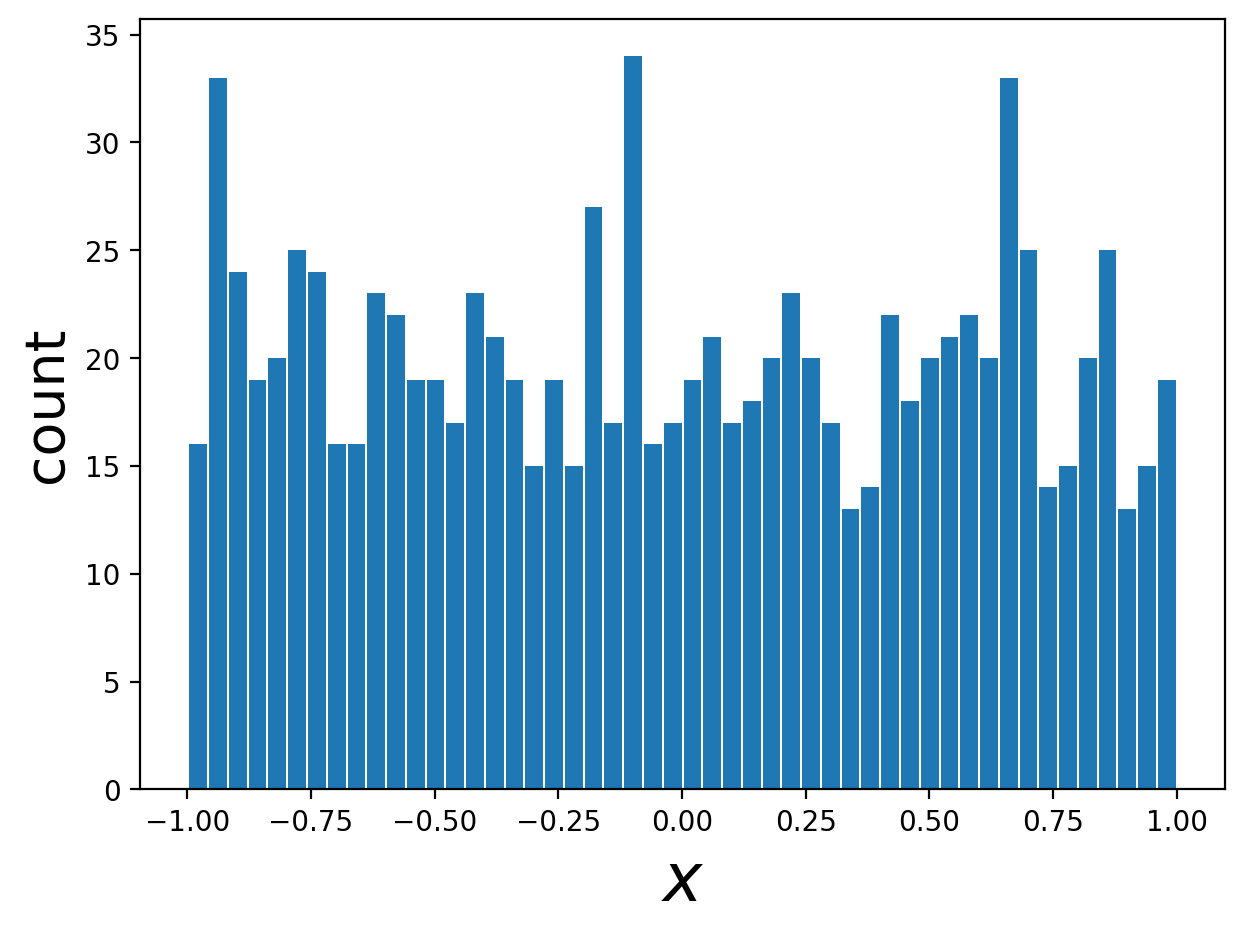

In [32]:
## Let's try uniform random variables first

a = -1. # left boundary
b = 1. # right boundary
n_samples = 1000

samples = stats.uniform.rvs(a, b-a, size=n_samples)
print('The first 10 samples:')
print(samples[:10]) ## print the first 10 samples

Nbins = 50
H, xvals = histogram(samples, bins=Nbins)
dx = xvals[1] - xvals[0]
x_to_plot = xvals[:-1] + dx/2

figure(1, [7, 5])
bar(x_to_plot, H, width=dx*0.9, label='histogram from\nrandom samples')
xlabel(r'$x$', fontsize=24)
ylabel('count', fontsize=20);

The first 10 samples:
[7 6 7 4 7 5 6 8 8 4]


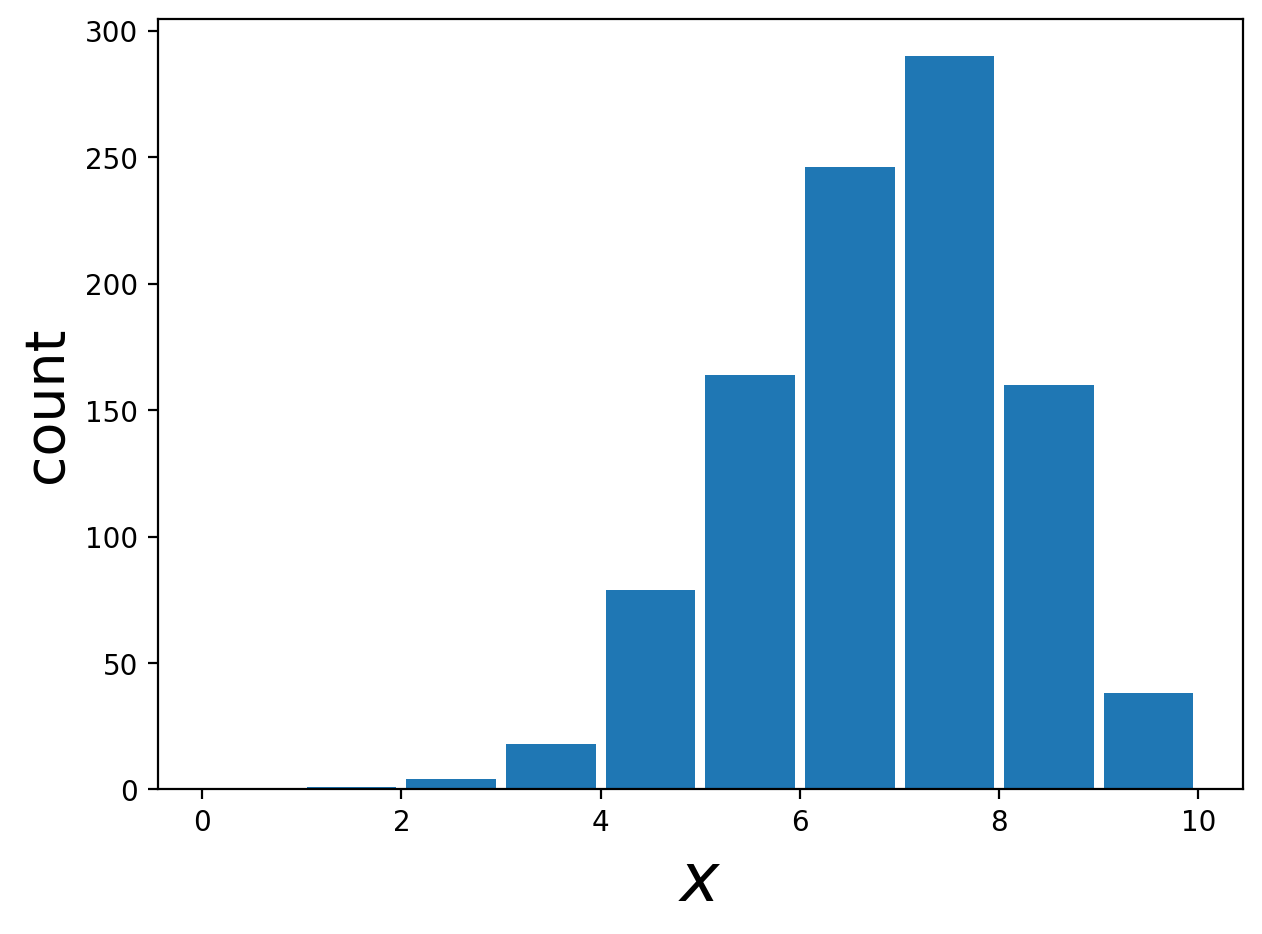

In [33]:
## Let's try binomial random variables

p = 0.7
n = 9
n_samples = 1000

samples = stats.binom.rvs(n, p, size=n_samples)
print('The first 10 samples:')
print(samples[:10]) ## print the first 10 samples

Nbins = n+1
H, xvals = histogram(samples, bins=Nbins, range=[0, n+1])
dx = xvals[1] - xvals[0]
x_to_plot = xvals[:-1] + dx/2

figure(1, [7, 5])
bar(x_to_plot, H, width=dx*0.9, label='histogram from\nrandom samples')
xlabel(r'$x$', fontsize=24)
ylabel('count', fontsize=20);

The first 10 samples:
[-1.51131846 -0.85499874  0.11406844 -2.24923324 -1.37217832  4.97911787
 -2.18081764 -3.8733236   0.98839125 -1.16166032]


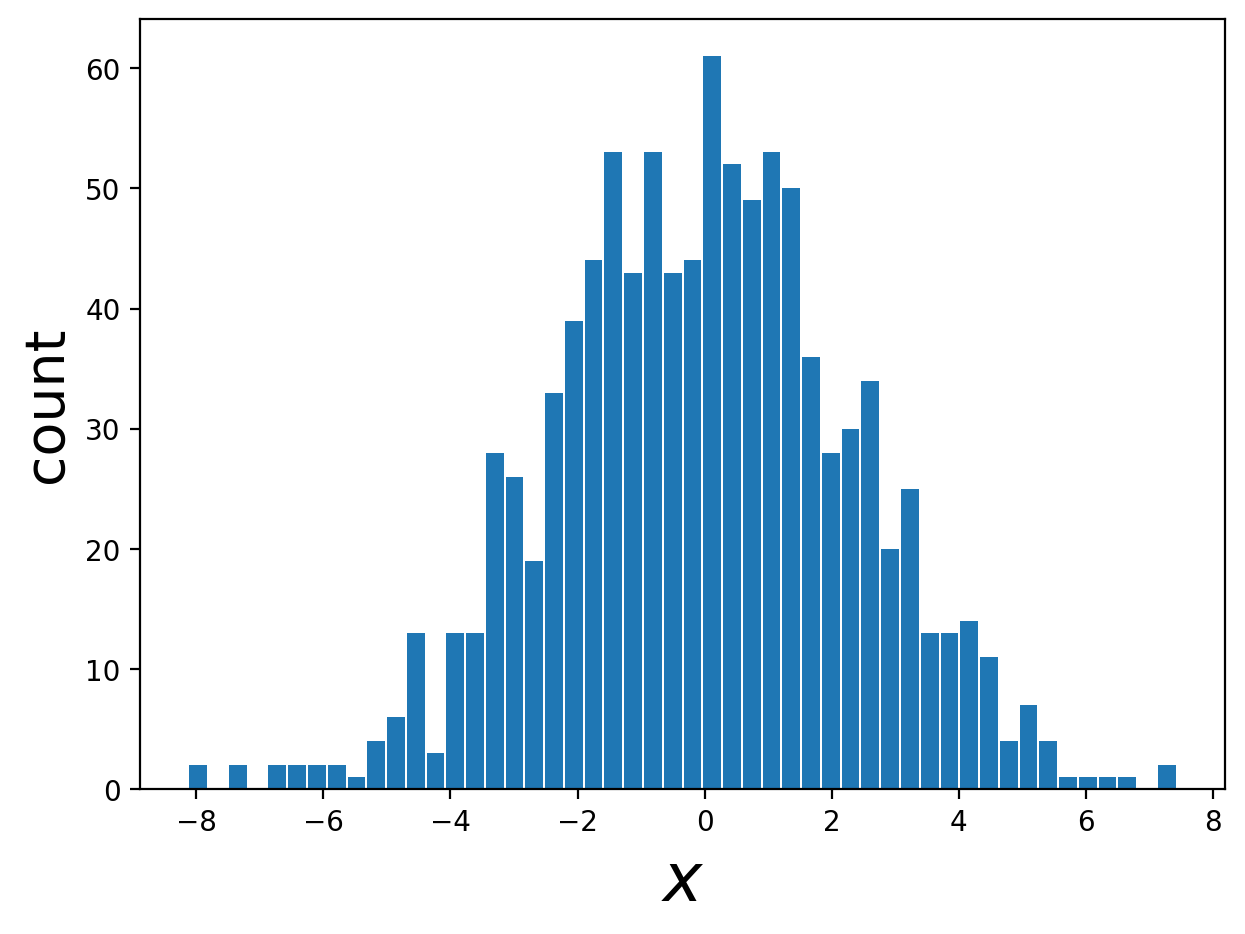

In [34]:
## Let's try normal random variables

mean = 0.
sigma = 2.3
n_samples = 1000

samples = stats.norm.rvs(mean, sigma, size=n_samples)
print('The first 10 samples:')
print(samples[:10]) ## print the first 10 samples

Nbins = 50
H, xvals = histogram(samples, bins=Nbins)
dx = xvals[1] - xvals[0]
x_to_plot = xvals[:-1] + dx/2

figure(1, [7, 5])
bar(x_to_plot, H, width=dx*0.9, label='histogram from\nrandom samples')
xlabel(r'$x$', fontsize=24)
ylabel('count', fontsize=20);

## Let's compare to the true distribution
We will need to normalize the histogram

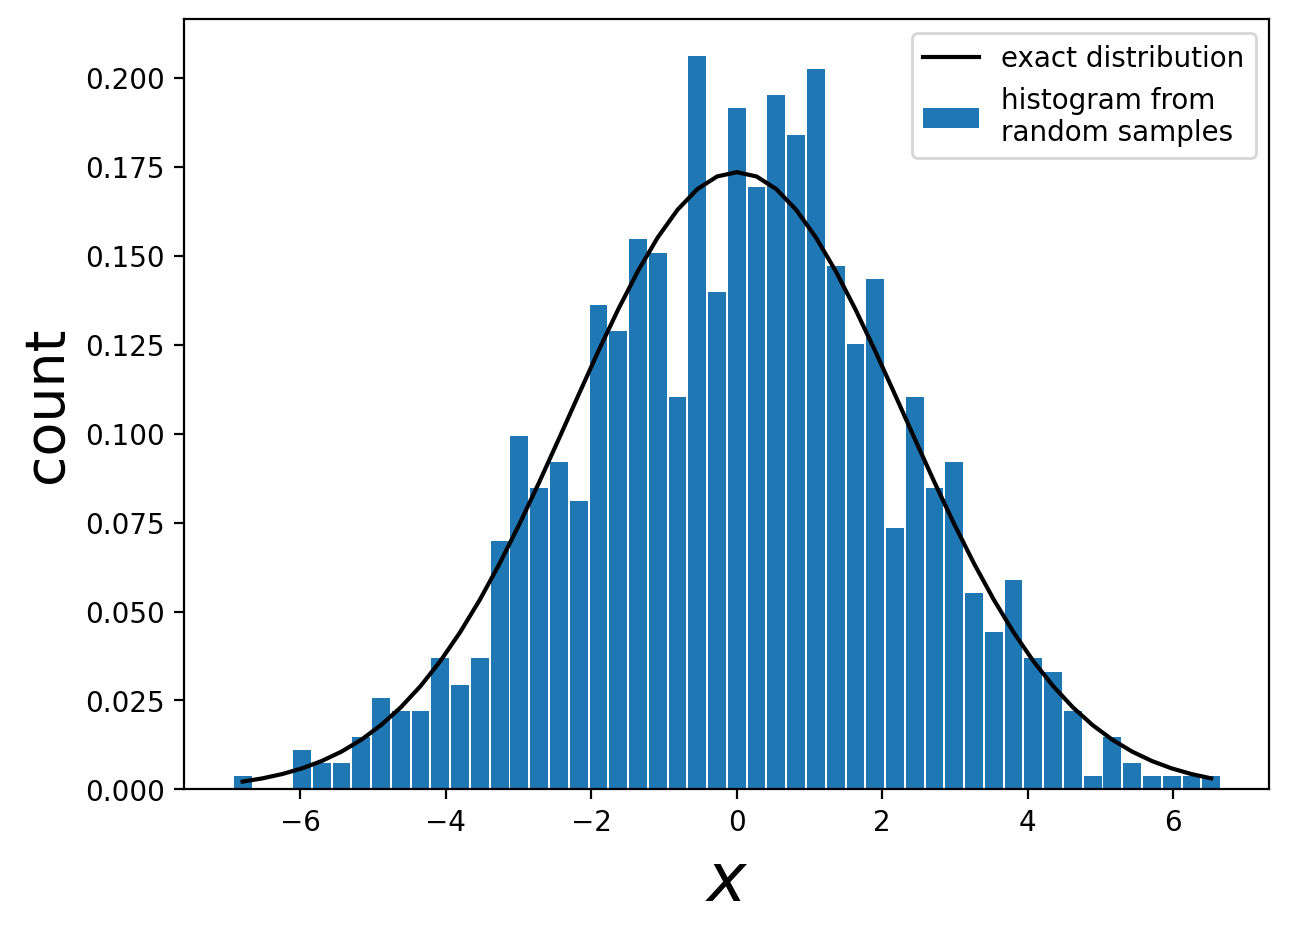

In [35]:
## normal random variables again

mean = 0.
sigma = 2.3
n_samples = 1000

samples = stats.norm.rvs(mean, sigma, size=n_samples)
Nbins = 50
H, xvals = histogram(samples, bins=Nbins)
dx = xvals[1] - xvals[0]
x_to_plot = xvals[:-1] + dx/2
H_normalized = H/sum(H*dx)

figure(1, [7, 5])
bar(x_to_plot, H_normalized, width=dx*0.9, label='histogram from\nrandom samples')
plot(x_to_plot, stats.norm.pdf(x_to_plot, mean, sigma), 'k', label='exact distribution')
legend()
xlabel(r'$x$', fontsize=24)
ylabel('count', fontsize=20);

## Globe example

Recall the example from Chapter 2, estimate the fraction of the earthâ€™s surface occupied by water (W) vs land (L).

The statistical model is

\begin{align}
W &\sim \text{Binomial}(N, p) \\
p &\sim \text{Uniform}(0, 1)
\end{align}

# Grid approximation

In [36]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9):
    ## define grid
    p_grid = linspace(0, 1, grid_points)

    ## define prior
    prior = ones_like(p_grid) ## an array of ones the same size and shape as `p_grid`
    # prior = int64(p_grid >= 0.5)
    # prior = exp(- 5 * absolute(p_grid - 0.5))  # double exp

    ## compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    ## compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    ## standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

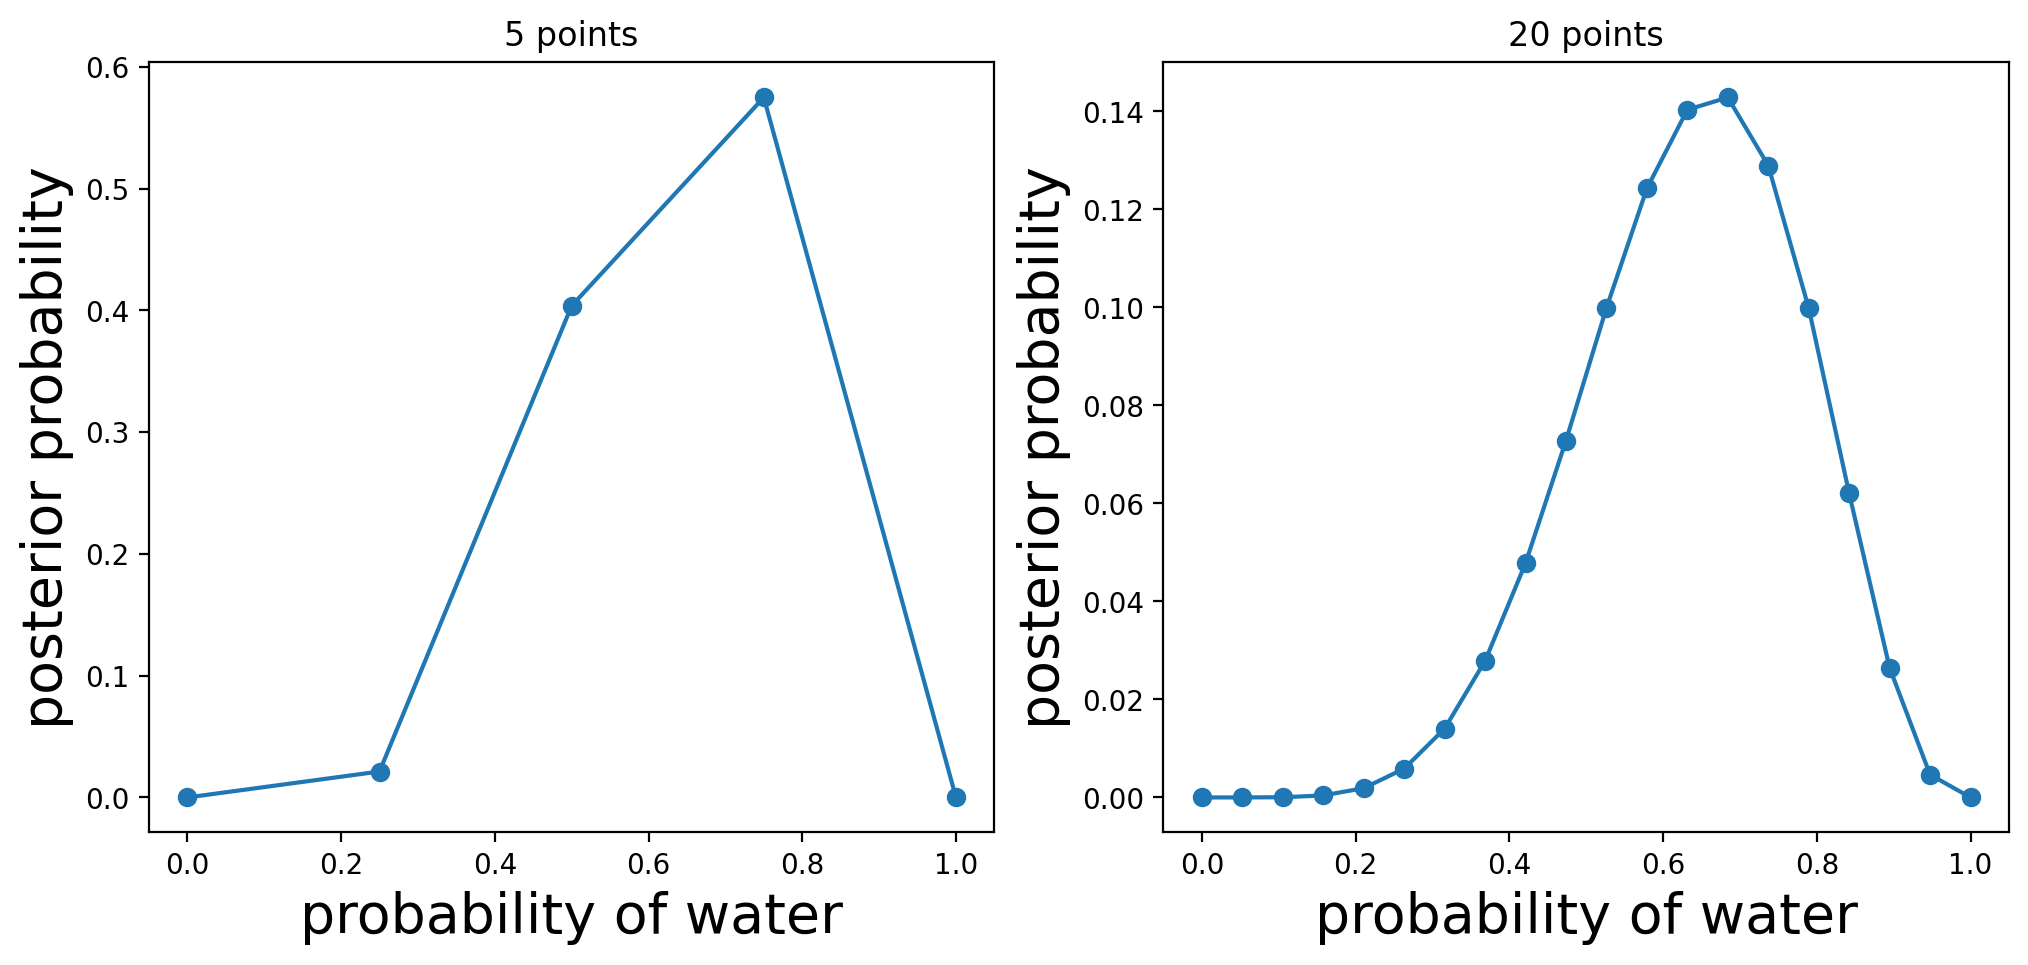

In [37]:
w = 6
n = 9

fig = figure(1, [12, 5])

fig.add_subplot(121) ## 121 means 1 by 2 grid of plots and the 1st plot
p_grid, posterior = posterior_grid_approx(5, w, n)
plot(p_grid, posterior, "o-")
xlabel("probability of water", fontsize=20)
ylabel("posterior probability", fontsize=20)
title('5 points')

fig.add_subplot(122) ## 121 means 1 by 2 grid of plots and the 2nd plot
p_grid, posterior = posterior_grid_approx(20, w, n)
plot(p_grid, posterior, "o-")
xlabel("probability of water", fontsize=20)
ylabel("posterior probability", fontsize=20)
title('20 points');

# "Quadratic" approximation
## (Skip this example for now)


# MCMC sampling
## Sample the posterior using the Metropolis algorithm

In [38]:
w = 6
n = 9
l = n - w
n_samples = 1000

p_mcmc_samples = zeros(n_samples)
p_mcmc_samples[0] = 0.5
for i in arange(1, n_samples):
    p_new = stats.norm(p_mcmc_samples[i - 1], 0.1).rvs(1)
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(w, n=w + l, p=p_mcmc_samples[i - 1])
    q1 = stats.binom.pmf(w, n=w + l, p=p_new)
    if stats.uniform.rvs(0, 1) < q1/q0:
        p_mcmc_samples[i] = p_new
    else:
        p_mcmc_samples[i] = p_mcmc_samples[i - 1]

# Exact sampling
## Sample from the exact posterior

In [39]:
w = 6
n = 9
n_samples = 1000 # number of samples TRY INCREASING THIS
p_exact_samples = stats.beta.rvs(w + 1, n - w + 1, size=n_samples)

## Let's use histograms (normalized for comparison to the true posterior)
This time I did not plot the histograms as bars

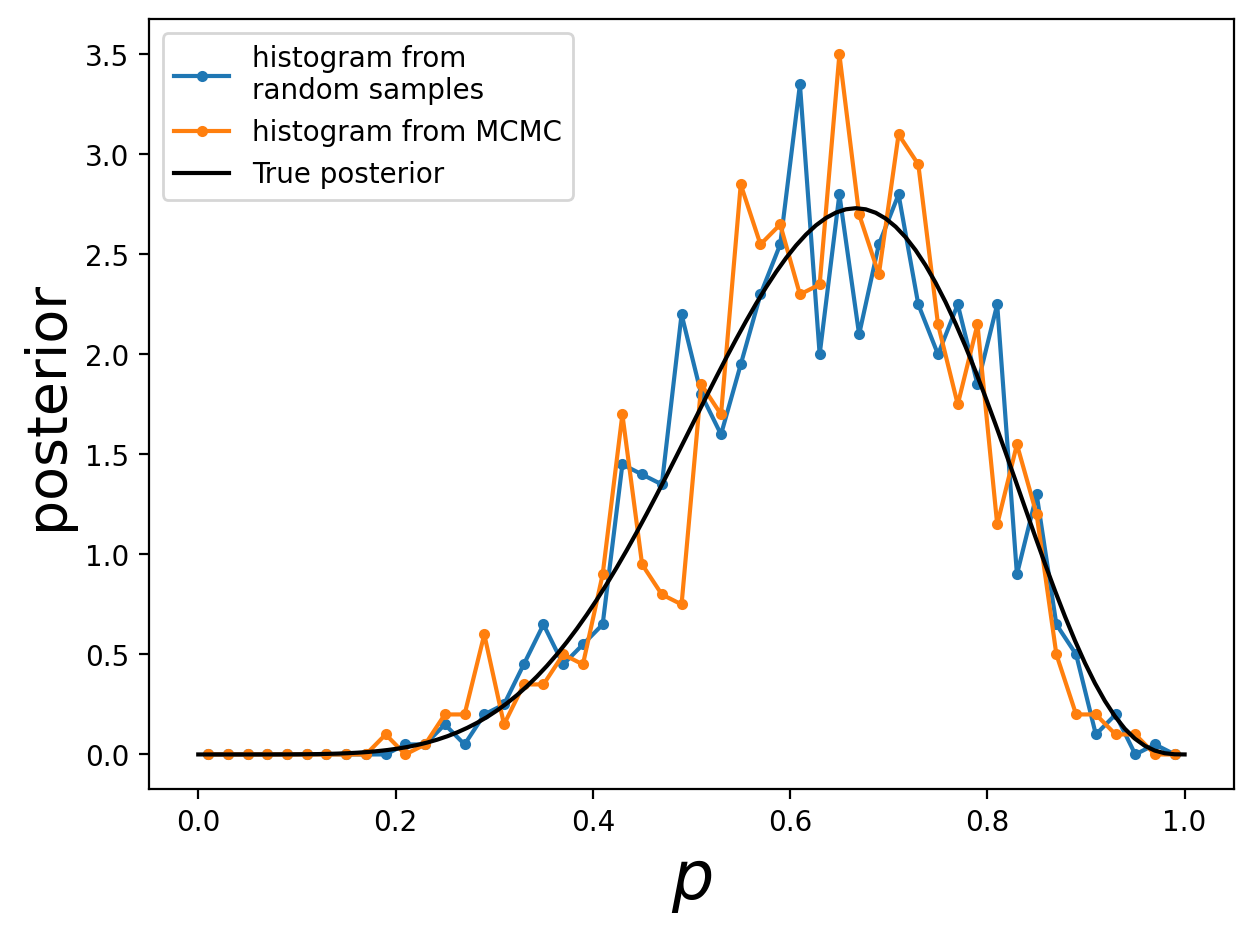

In [40]:
Nbins = 50
H, xvals = histogram(p_exact_samples, bins=Nbins, range=[0, 1])
H_mcmc, _ = histogram(p_mcmc_samples, bins=Nbins, range=[0, 1])
dx = xvals[1] - xvals[0]
x_to_plot = xvals[:-1] + dx/2
H_normalized = H/sum(H*dx) # numerical integration to normalize
H_mcmc_normalized = H_mcmc/sum(H_mcmc*dx)

figure(1, [7, 5])


plot(x_to_plot, H_normalized, '.-', label='histogram from\nrandom samples')
plot(x_to_plot, H_mcmc_normalized, '.-', label='histogram from MCMC')
plot(x, stats.beta.pdf(x, w + 1, n - w + 1), 'k', label="True posterior")

xlabel(r'$p$', fontsize=24)
ylabel('posterior', fontsize=20)
legend();

## Kernel density estimation
### The book uses this instead of histograms
### Think of it as a kind of "smooth histogram"


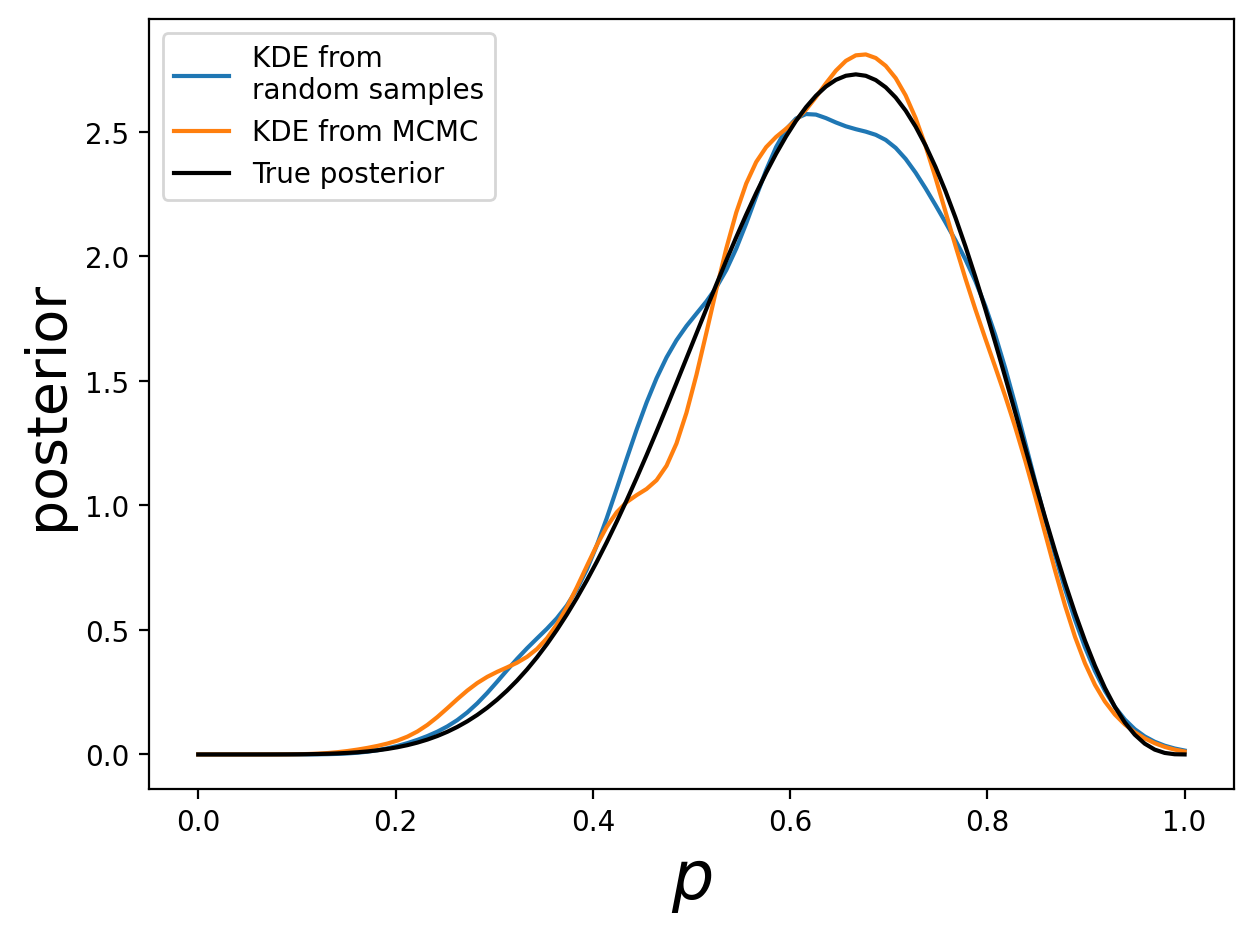

In [41]:
x_to_plot = linspace(0, 1, 100)

kde_exact_pdf = stats.gaussian_kde(p_exact_samples)
kde_mcmc_pdf = stats.gaussian_kde(p_mcmc_samples)

figure(1, [7, 5])

plot(x_to_plot, kde_exact_pdf(x_to_plot), label='KDE from\nrandom samples')
plot(x_to_plot, kde_mcmc_pdf(x_to_plot), label='KDE from MCMC')
plot(x_to_plot, stats.beta.pdf(x_to_plot, w + 1, n - w + 1), 'k', label="True posterior")

xlabel(r'$p$', fontsize=24)
ylabel('posterior', fontsize=20)
legend();

### The same figure using the `seaborn` package KDE plot

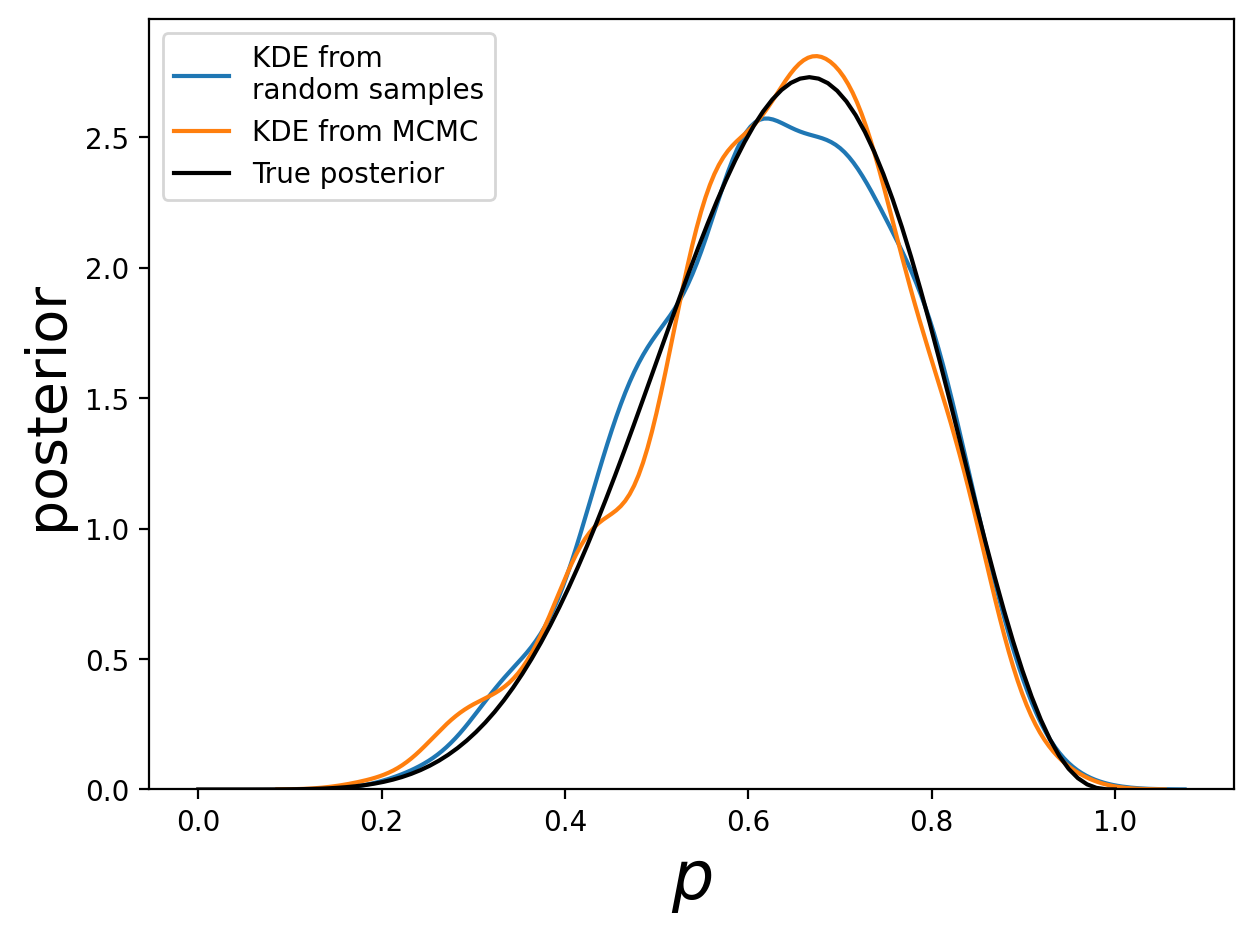

In [42]:
import seaborn as sns
# ?sns.kdeplot

x_to_plot = linspace(0, 1, 100)

figure(1, [7, 5])


sns.kdeplot(p_exact_samples, label='KDE from\nrandom samples')
sns.kdeplot(p_mcmc_samples, label='KDE from MCMC')
plot(x_to_plot, stats.beta.pdf(x_to_plot, w + 1, n - w + 1), 'k', label="True posterior")

xlabel(r'$p$', fontsize=24)
ylabel('posterior', fontsize=20)
legend();